# 1. Import libraries

In [ ]:
from google.colab import drive

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras import layers

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout

import matplotlib.pyplot as plt

import math


# 2. Prepare data

In [ ]:
# Montamos el Google Drive en el directorio del proyecto y descomprimios el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/DL_master/RT-BENE.zip' >> /dev/null

Mounted at /content/gdrive


In [ ]:
# Especificamos los paths al directorio que contiene las imagenes y al fichero con las etiquetas
data_path = 'RT-BENE/'
imgs_path = data_path + "images/"
labels_path = data_path + "blinks.csv"

# Leemos el fichero CSV con las etiquetas
labels = pd.read_csv(labels_path, dtype = {"blink": "category"})

# Creamos las tres particiones de datos: entrenamiento, validación y test
seed = 0
train_data, test_data, _, _ = train_test_split(labels, labels["video"], test_size=0.2, random_state=seed, stratify=labels["video"])
dev_data, test_data, _, _ = train_test_split(test_data, test_data["video"], test_size=0.5, random_state=seed, stratify=test_data["video"])

# Actualizamos los indices de cada particion
train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Reescalamos las imagenes para que los datos se encuentren entre 0 y 1
datagen = ImageDataGenerator(rescale=1./255)

# Especificamos una serie de parámetros dependientes del conjunto de datos
left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'
batch_size = 128
img_width = 60
img_height = 36
seed = 0

# Generador custom que devuelve las dos imagenes de ojos y el label del parpadeo
def generator(dataframe, shuffle):
  left_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
      directory = imgs_path,
      target_size =(img_width, img_height),
      x_col=left_eye_col,
      y_col=y_col,
      class_mode="binary",
      seed=seed,
      batch_size=batch_size,
      shuffle=shuffle)
  right_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
      directory = imgs_path,
      target_size =(img_width, img_height),
      x_col=right_eye_col,
      y_col=y_col,
      class_mode="binary",
      seed=seed,
      batch_size=batch_size,
      shuffle=shuffle)
  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield [left_eye_image, right_eye_image], label


# 3. Setup network

In [ ]:
# Desbalanceo de clases
class_count = train_data.groupby("blink")["blink_id"].count()
class_count

blink
0    82258
1     3622
Name: blink_id, dtype: int64

In [ ]:
# Calculamos el ratio de balanceo que utilizaremos posteriormente
balance_rate = class_count.values[0]/class_count.values[1]
balance_rate

22.71065709552733

In [ ]:
# Definimos el input de entrada de la red
input_shape = (60, 36, 3)

# Declaramos dos capas de Input
input_izq = Input(shape=input_shape)
input_der = Input(shape=input_shape)

# Cargamos los modelos MobileNetV2 pre-entrenados con ImageNet (uno para cada ojo), sin incluir la parte alta de la red
base_model_izq = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=input_izq)
base_model_der = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=input_der)

# En este ejemplo vamos a ajustar los parámetros de las nuevas capas del modelo,
# dejando fijos los parámetros del resto de capa (es decir, que no se actualicen durante el entrenamiento)
for layer in base_model_izq.layers:
    layer.trainable = False   # por defecto, el valor de trainable es True
    layer._name = f"{layer.name}_izq"
for layer in base_model_der.layers:
    layer.trainable = False   # por defecto, el valor de trainable es True
    layer._name = f"{layer.name}_der"


# Añadimos nuevas capas al final para adaptar el modelo a nuestro problema, siguiendo el esquema previo de MobileNetV2
x_izq = base_model_izq.output
x_izq = GlobalAveragePooling2D()(x_izq)

x_der = base_model_der.output
x_der = GlobalAveragePooling2D()(x_der)


# Concatenamos el final de las capas intermedias de cada una de las redes preentrenadas para cada ojo
# en una sola línea de capas que comprenderán las capas densas o capas altas de la red final
x = layers.concatenate([x_izq, x_der])
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Añadimos la capa final con activación "sigmoid" al tratarse de un problema de clasificación binaria
predictions = Dense(1, activation='sigmoid')(x) 

# Se establecen pesos para tratar el problema de desbalanceo entre clases
class_weight = {0: 1.,
                1: balance_rate}

# Creamos el modelo final y lo compilamos
model = Model(inputs=[input_izq, input_der], outputs=[predictions])
model.summary()

  lr0 = 1e-3
  model.compile(loss='binary_crossentropy',    
                optimizer=optimizers.Adam(learning_rate=lr0),  # optimizador Adam
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

train_generator = generator(train_data, True)
test_generator = generator(test_data, True)
dev_generator = generator(dev_data, True)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def scheduler(epoch, lr):
   drop = 0.2
   lr = lr - (lr * drop)
   return lr

lrate = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenamos el modelo
history = model.fit(train_generator,
          epochs=15,  # numero de epochs
          verbose=1,  # muestra informacion del error al finalizar cada epoch
          steps_per_epoch=len(train_data)/batch_size,
          validation_data=dev_generator,
          validation_steps=len(dev_data)/batch_size,
          class_weight = class_weight,
          callbacks=[earlystop, lrate]
          )

# Por ultimo, podemos evaluar el modelo en el conjunto de test
print()
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_generator,
                                     steps=len(test_data)/batch_size,
                                     verbose=1)

print("test_loss: %.4f, test_acc: %.4f, test_prec: %.4f, test_recall: %.4f" % (test_loss, test_acc, test_prec, test_recall))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11_izq (InputLayer)      [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 input_12_der (InputLayer)      [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 Conv1_izq (Conv2D)             (None, 30, 18, 32)   864         ['input_11_izq[0][0]']           
                                                                                                  
 Conv1_der (Conv2D)             (None, 30, 18, 32)   864         ['input_12_der[0][0]']           
                                                                                            

# 4. Evaluate

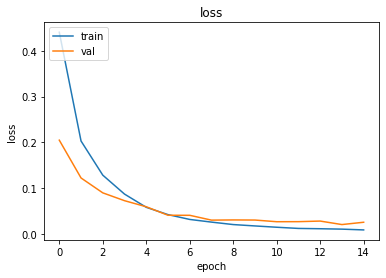

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model.save("model", save_format="h5")

In [ ]:
test_generator = generator(test_data, shuffle=False)
predictions = model.predict(test_generator, steps=len(test_data)/batch_size)>0.5

Found 10735 validated image filenames belonging to 2 classes.
Found 10735 validated image filenames belonging to 2 classes.


In [ ]:
predictions=predictions.astype(int)

In [ ]:
test_data["blink"].astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
10730    0
10731    0
10732    0
10733    0
10734    0
Name: blink, Length: 10735, dtype: int64

In [ ]:
res = tf.math.confusion_matrix(test_data["blink"].astype(int),predictions)
print('Confusion_matrix: ',res)

Confusion_matrix:  tf.Tensor(
[[10219    51]
 [   43   422]], shape=(2, 2), dtype=int32)


In [ ]:
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_generator,
                                     steps=len(test_data)/batch_size,
                                     verbose=1)

83/83 [==============================] - 16s 188ms/step - loss: 0.0288 - accuracy: 0.9912 - precision_5: 0.8922 - recall_5: 0.9075
